### import the dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchdiffeq import odeint

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

DATA_PATH = os.path.join("..", "Dataset", "raw_RRI_segments.csv")
OUT_MODEL = os.path.join("..", "Three_Class_Models", "saved_models", "PSR_hybrid_best.pth")

### Load PSR dataset and preprocess

In [2]:
df = pd.read_csv(DATA_PATH)
# pick RRI feature columns (prefix 'r_')
feature_cols = [c for c in df.columns if c.startswith("r_")]
meta_cols = ["patient_id", "record_id", "label", "label_str", "orig_len"]

assert len(feature_cols) > 0, "No r_ columns found in CSV"


In [3]:
def phase_space_reconstruct(x, m=3, tau=1):
    """
    x: 1D array of RRI
    m: embedding dimension
    tau: time delay
    Returns flattened PSR embedding: x(t), x(t+tau), ..., x(t+(m-1)*tau)
    """
    x = np.asarray(x)
    N = len(x)
    if N < (m-1)*tau + 1:
        # pad with zeros if too short
        x = np.pad(x, (0, (m-1)*tau + 1 - N), 'constant')
        N = len(x)
    psr_vectors = [x[i:N-(m-1)*tau + i] for i in range(m)]
    psr_flat = np.column_stack(psr_vectors).flatten()
    return psr_flat

# Pick RRI columns
rri_cols = [f"r_{i}" for i in range(50)]

# Compute PSR for all rows with m=3, tau=2
psr_features = df[rri_cols].apply(lambda row: phase_space_reconstruct(row.values, m=3, tau=2), axis=1)
psr_features = np.stack(psr_features.values)  # shape: (num_samples, m*(N-(m-1)*tau))

# Add PSR columns to DataFrame
num_psr_cols = psr_features.shape[1]
psr_col_names = [f"psr_{i}" for i in range(num_psr_cols)]
df_psr = pd.DataFrame(psr_features, columns=psr_col_names, index=df.index)
df = pd.concat([df, df_psr], axis=1)

print("PSR features added (m=3, tau=2). DataFrame shape:", df.shape)




PSR features added (m=3, tau=2). DataFrame shape: (14357, 193)


In [4]:
feature_cols = psr_col_names
meta_cols = ["patient_id", "record_id", "label", "label_str", "orig_len"]

# Feature matrix X
X = df[feature_cols].values.astype(np.float32)

# Keep label as float first (to handle NaN/inf safely)
y_raw = df["label"].values

# Step 1: Drop rows with invalid X (NaN or inf)
mask_good = np.isfinite(X).all(axis=1)

# Step 2: Drop invalid labels (NaN, inf, negative)
mask_good &= np.isfinite(y_raw) & (y_raw >= 0)

# Apply combined mask
X = X[mask_good]
y = y_raw[mask_good].astype(int)

# Step 3: Inspect
print(np.unique(y)[:10])   # print first few unique labels
print(y[:20])

# Step 4: Safe bincount
print("Loaded samples:", X.shape, "class counts:", np.bincount(y))


[0 1 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Loaded samples: (14357, 138) class counts: [4800 4757 4800]


### Train / val / test split, scaling and SMOTE (apply SMOTE only to training set)

In [5]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=RANDOM_SEED
)

print("Splits -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

# Standardize using training stats
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_res, y_train_res = X_train, y_train


Splits -> train: (9188, 138) val: (2297, 138) test: (2872, 138)


### Define model class

In [6]:
# --- Model definitions (Hybrid NODE + Attention) ---
class ODEFunc(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 64),
            nn.Tanh(),
            nn.Linear(64, dim)
        )
    def forward(self, t, x):
        return self.net(x)

class SelfAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.scale = dim ** 0.5
    def forward(self, x):
        # x: [batch, dim] -> [batch, 1, dim]
        x1 = x.unsqueeze(1)
        Q = self.query(x1)
        K = self.key(x1)
        V = self.value(x1)
        scores = torch.softmax(torch.bmm(Q, K.transpose(1,2)) / self.scale, dim=-1)
        out = torch.bmm(scores, V)  # [batch,1,dim]
        return out.squeeze(1)

class HybridNODEAttentionModel(nn.Module):
    def __init__(self, dim, num_classes):
        super().__init__()
        self.odefunc = ODEFunc(dim)
        self.attn = SelfAttention(dim)
        self.classifier = nn.Sequential(
            nn.Linear(dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        # x: [batch, dim]
        t = torch.tensor([0.0, 1.0], dtype=x.dtype, device=x.device)
        ode_out = odeint(self.odefunc, x, t)[-1]
        attn_out = self.attn(ode_out)
        return self.classifier(attn_out)


### Prepare DataLoaders

In [7]:
BATCH_SIZE = 32
train_ds = TensorDataset(torch.from_numpy(X_train_res.astype(np.float32)), torch.from_numpy(y_train_res.astype(np.int64)))
val_ds = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.int64)))
test_ds = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)

### Train model (k-fold + hyperparameter tuning)

In [8]:
import itertools
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import torch
import torch.nn.functional as F
import torch.optim as optim         
from torch.utils.data import DataLoader, Subset
 

def train_with_kfold_tuning(model_class, input_dim, num_classes,
                            full_dataset,
                            param_grid,
                            save_path,
                            epochs=8, patience=2,
                            k_folds=5, device='cuda'):
    best_global_f1 = 0.0
    best_params = None
    best_state = None

    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    combos = list(itertools.product(*param_grid.values()))
    print(f"Total combinations: {len(combos)}  |  Using {k_folds}-fold cross-validation")

    for combo in combos:
        params = dict(zip(param_grid.keys(), combo))
        print(f"\nTesting hyperparameters: {params}")
        fold_f1s = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(np.arange(len(full_dataset)))):
            train_subset = Subset(full_dataset, train_idx)
            val_subset = Subset(full_dataset, val_idx)

            train_loader = DataLoader(train_subset, batch_size=params["batch_size"], shuffle=True)
            val_loader = DataLoader(val_subset, batch_size=params["batch_size"], shuffle=False)

            # --- Model + Optimizer + Criterion ---
            model = model_class(dim=input_dim, num_classes=num_classes).to(device)
            
            if params["optimizer"] == "adam":
                optimizer = optim.Adam(model.parameters(), lr=params["lr"])
            elif params["optimizer"] == "sgd":
                optimizer = optim.SGD(model.parameters(), lr=params["lr"], momentum=0.9)
            else:
                raise ValueError(f"Unknown optimizer: {params['optimizer']}")

            criterion = nn.CrossEntropyLoss()

            # --- Training loop ---
            local_best = 0.0
            no_improve = 0

            for epoch in range(epochs):
                model.train()
                total_loss = 0
                for xb, yb in train_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    optimizer.zero_grad()
                    out = model(xb)
                    loss = criterion(out, yb)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item() * xb.size(0)

                # --- Validation ---
                model.eval()
                preds, trues = [], []
                with torch.no_grad():
                    for xb, yb in val_loader:
                        xb, yb = xb.to(device), yb.to(device)
                        out = model(xb)
                        preds.extend(torch.argmax(out, dim=1).cpu().numpy())
                        trues.extend(yb.cpu().numpy())

                val_f1 = f1_score(trues, preds, average="weighted")
                if val_f1 > local_best:
                    local_best = val_f1
                    no_improve = 0
                else:
                    no_improve += 1
                    if no_improve >= patience:
                        break

            fold_f1s.append(local_best)
            print(f"  Fold {fold+1}/{k_folds} F1: {local_best:.4f}")

        mean_f1 = np.mean(fold_f1s)
        print(f"Mean F1 for params {params}: {mean_f1:.4f}")

        if mean_f1 > best_global_f1:
            best_global_f1 = mean_f1
            best_params = params
            best_state = model.state_dict().copy()
            torch.save(best_state, save_path)
            print("  ✅ New best model saved.")

    print(f"\nBest overall F1: {best_global_f1:.4f} with params {best_params}")
    return best_params, best_global_f1, best_state


In [9]:
train_dataset = TensorDataset(torch.from_numpy(X_train_res.astype(np.float32)), torch.from_numpy(y_train_res.astype(np.int64)))
val_dataset = TensorDataset(torch.from_numpy(X_val.astype(np.float32)), torch.from_numpy(y_val.astype(np.int64)))
test_dataset = TensorDataset(torch.from_numpy(X_test.astype(np.float32)), torch.from_numpy(y_test.astype(np.int64)))

input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)

In [10]:
full_dataset = TensorDataset(
    torch.from_numpy(X_train_res.astype(np.float32)),
    torch.from_numpy(y_train_res.astype(np.int64))
)

param_grid = {
    "lr": [1e-3, 5e-4],
    "batch_size": [16, 32],
    "optimizer": ["adam", "sgd"]
}

best_params, best_f1, best_state = train_with_kfold_tuning(
    HybridNODEAttentionModel, input_dim, num_classes,
    full_dataset,
    param_grid, save_path=OUT_MODEL,
    epochs=8, patience=2, k_folds=5, device=device
)


Total combinations: 8  |  Using 5-fold cross-validation

Testing hyperparameters: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}
  Fold 1/5 F1: 0.6035
  Fold 2/5 F1: 0.6348
  Fold 3/5 F1: 0.6473
  Fold 4/5 F1: 0.6016
  Fold 5/5 F1: 0.6163
Mean F1 for params {'lr': 0.001, 'batch_size': 16, 'optimizer': 'adam'}: 0.6207
  ✅ New best model saved.

Testing hyperparameters: {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}
  Fold 1/5 F1: 0.6112
  Fold 2/5 F1: 0.6008
  Fold 3/5 F1: 0.6181
  Fold 4/5 F1: 0.5866
  Fold 5/5 F1: 0.5924
Mean F1 for params {'lr': 0.001, 'batch_size': 16, 'optimizer': 'sgd'}: 0.6018

Testing hyperparameters: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}
  Fold 1/5 F1: 0.6299
  Fold 2/5 F1: 0.6023
  Fold 3/5 F1: 0.6477
  Fold 4/5 F1: 0.6219
  Fold 5/5 F1: 0.5995
Mean F1 for params {'lr': 0.001, 'batch_size': 32, 'optimizer': 'adam'}: 0.6203

Testing hyperparameters: {'lr': 0.001, 'batch_size': 32, 'optimizer': 'sgd'}
  Fold 1/5 F1: 0.6028
  Fold 2/5 F1

### Final evaluation on test set

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import numpy as np
import torch

# --- Load best model for final evaluation ---
if best_state is not None:
    best_model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes)
    best_model.load_state_dict(best_state)
    best_model = best_model.to(device)
    print("✅ Loaded best model from training.")
else:
    best_model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes).to(device)
    print("⚠️ No best_state found, using new untrained model.")

# --- Create test loader if missing ---
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Evaluate on test set ---
best_model.eval()
test_preds, test_trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = best_model(xb)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_trues.extend(yb.cpu().numpy())

test_preds = np.array(test_preds)
test_trues = np.array(test_trues)

# --- Metrics ---
acc = accuracy_score(test_trues, test_preds)
f1 = f1_score(test_trues, test_preds, average="weighted")
precision = precision_score(test_trues, test_preds, average="weighted", zero_division=0)
recall = recall_score(test_trues, test_preds, average="weighted", zero_division=0)
cm = confusion_matrix(test_trues, test_preds)

print("\n📊 Final Test Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

print("\nDetailed classification report:")
print(classification_report(test_trues, test_preds, digits=4))

print("\nConfusion Matrix:")
print(cm)


✅ Loaded best model from training.

📊 Final Test Results:
Accuracy:  0.6194
F1 Score:  0.6086
Precision: 0.6075
Recall:    0.6194

Detailed classification report:
              precision    recall  f1-score   support

           0     0.5256    0.5458    0.5355       960
           1     0.5512    0.4244    0.4795       952
           2     0.7452    0.8865    0.8097       960

    accuracy                         0.6194      2872
   macro avg     0.6073    0.6189    0.6082      2872
weighted avg     0.6075    0.6194    0.6086      2872


Confusion Matrix:
[[524 285 151]
 [408 404 140]
 [ 65  44 851]]


In [12]:
input_dim = X_train_res.shape[1]
num_classes = int(np.unique(y).size)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes).to(DEVICE)
state_dict = torch.load(OUT_MODEL, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()
print("✅ Loaded trained NODE model from", OUT_MODEL)

✅ Loaded trained NODE model from ../Three_Class_Models/saved_models/PSR_hybrid_best.pth


In [13]:
import torch
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import numpy as np

# --- Load model from saved .pth ---
model_path = os.path.join("..", "Three_Class_Models", "saved_models", "PSR_hybrid_best.pth")

# ✅ use the exact same model class you trained
best_model = HybridNODEAttentionModel(dim=input_dim, num_classes=num_classes).to(device)

# ✅ load trained weights
state_dict = torch.load(model_path, map_location=device)
best_model.load_state_dict(state_dict)
best_model.eval()
print(f"✅ Loaded trained model from: {model_path}")

# --- Evaluate on test set ---
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_preds, test_trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = best_model(xb)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_trues.extend(yb.cpu().numpy())

test_preds = np.array(test_preds)
test_trues = np.array(test_trues)

# --- Compute metrics ---
acc = accuracy_score(test_trues, test_preds)
f1 = f1_score(test_trues, test_preds, average="weighted")
precision = precision_score(test_trues, test_preds, average="weighted", zero_division=0)
recall = recall_score(test_trues, test_preds, average="weighted", zero_division=0)
cm = confusion_matrix(test_trues, test_preds)

print("\n📊 Final Test Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

print("\nDetailed classification report:")
print(classification_report(test_trues, test_preds, digits=4))

print("\nConfusion Matrix:")
print(cm)


✅ Loaded trained model from: ../Three_Class_Models/saved_models/PSR_hybrid_best.pth

📊 Final Test Results:
Accuracy:  0.6194
F1 Score:  0.6086
Precision: 0.6075
Recall:    0.6194

Detailed classification report:
              precision    recall  f1-score   support

           0     0.5256    0.5458    0.5355       960
           1     0.5512    0.4244    0.4795       952
           2     0.7452    0.8865    0.8097       960

    accuracy                         0.6194      2872
   macro avg     0.6073    0.6189    0.6082      2872
weighted avg     0.6075    0.6194    0.6086      2872


Confusion Matrix:
[[524 285 151]
 [408 404 140]
 [ 65  44 851]]


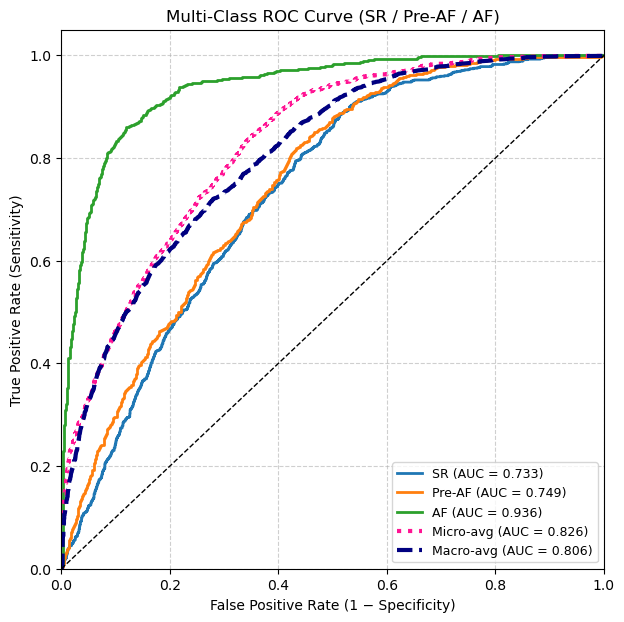

AUC[SR] = 0.7329
AUC[Pre-AF] = 0.7494
AUC[AF] = 0.9358
Micro-avg AUC = 0.8259
Macro-avg AUC = 0.8063


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

num_classes = 3
y_all = [label for _, label in test_dataset]
y_true = np.array(y_all)  # labels: 0=SR, 1=Pre-AF, 2=AF

# --- Compute full probability matrix [N, 3] ---
probs_all = []

model.eval()
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1).cpu().numpy()
        probs_all.append(probs)

probs_all = np.vstack(probs_all)   # shape [n_samples, 3]

# --- One-hot encode true labels ---
y_bin = label_binarize(y_true, classes=[0, 1, 2])

# --- Compute ROC curve & AUC for each class ---
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs_all[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Compute micro- and macro-average ROC ---
fpr["micro"], tpr["micro"], _ = roc_curve(y_bin.ravel(), probs_all.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all FPRs
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# --- Plot ---
plt.figure(figsize=(7,7))
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
class_names = ["SR", "Pre-AF", "AF"]

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.3f})")

plt.plot(fpr["micro"], tpr["micro"], color="deeppink", linestyle=":", linewidth=3,
         label=f"Micro-avg (AUC = {roc_auc['micro']:.3f})")
plt.plot(fpr["macro"], tpr["macro"], color="navy", linestyle="--", linewidth=3,
         label=f"Macro-avg (AUC = {roc_auc['macro']:.3f})")

plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel("False Positive Rate (1 − Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("Multi-Class ROC Curve (SR / Pre-AF / AF)")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# --- Print numeric results ---
for i, name in enumerate(class_names):
    print(f"AUC[{name}] = {roc_auc[i]:.4f}")
print(f"Micro-avg AUC = {roc_auc['micro']:.4f}")
print(f"Macro-avg AUC = {roc_auc['macro']:.4f}")


### Find Threshold using validation data

In [28]:
# --- Create validation loader ---
val_dataset = TensorDataset(
    torch.from_numpy(X_val.astype(np.float32)),
    torch.from_numpy(y_val.astype(np.int64))
)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- Compute danger probabilities (VAL SET) ---
prob_danger_val, true_danger_val = [], []

model.eval()
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1)  # shape [batch, 3]

        # P(SR) = probs[:,0], so danger = 1 - SR
        p_sr = probs[:, 0]
        p_danger = 1 - p_sr

        prob_danger_val.extend(p_danger.cpu().numpy())

        # Convert labels → binary danger: SR=0, (Pre-AF + AF)=1
        true_danger_val.extend((yb.numpy() != 0).astype(int))

prob_danger_val = np.array(prob_danger_val)
true_danger_val = np.array(true_danger_val)

print("🔍 Validation danger probability range:",
      prob_danger_val.min(), "-", prob_danger_val.max())
print("Validation danger label distribution:",
      np.bincount(true_danger_val))

# --- Sweep thresholds (VAL SET) ---
candidates = np.arange(0.0, 1.01, 0.01)
f1s, accs, precs, recs = [], [], [], []

for t in candidates:
    preds = (prob_danger_val >= t).astype(int)

    f1s.append(f1_score(true_danger_val, preds))
    accs.append(accuracy_score(true_danger_val, preds))
    precs.append(precision_score(true_danger_val, preds, zero_division=0))
    recs.append(recall_score(true_danger_val, preds))

max_f = max(f1s)
cut = 0.96 * max_f 

valid_idxs = [i for i, f in enumerate(f1s) if f >= cut]

# choose the largest threshold among valid candidates
best_idx = max(valid_idxs)
best_t = candidates[best_idx]

print(f"\n🎯 BEST THRESHOLD (96% F1 rule) = {best_t:.3f}")
print(f"Max F1 = {max_f:.4f}")
print(f"Chosen threshold F1 = {f1s[best_idx]:.4f}, Acc = {accs[best_idx]:.4f}, "
      f"Prec = {precs[best_idx]:.4f}, Rec = {recs[best_idx]:.4f}")

# Final threshold used in inference
window_threshold = best_t


🔍 Validation danger probability range: 0.29861784 - 0.9993365
Validation danger label distribution: [ 768 1529]

🎯 BEST THRESHOLD (96% F1 rule) = 0.560
Max F1 = 0.8015
Chosen threshold F1 = 0.7709, Acc = 0.6983, Prec = 0.7794, Rec = 0.7626


In [29]:
# --- Show all thresholds with F1 and Accuracy ---
print("\n========== Threshold Summary ==========")
print(f"{'Threshold':<10} {'F1':<10} {'Accuracy':<10}")
print("-" * 35)

for i, t in enumerate(candidates):
    print(f"{t:<10.2f} {f1s[i]:<10.4f} {accs[i]:<10.4f}")




========== Threshold Summary ==========
Threshold  F1         Accuracy  
-----------------------------------
0.00       0.7993     0.6657    
0.01       0.7993     0.6657    
0.02       0.7993     0.6657    
0.03       0.7993     0.6657    
0.04       0.7993     0.6657    
0.05       0.7993     0.6657    
0.06       0.7993     0.6657    
0.07       0.7993     0.6657    
0.08       0.7993     0.6657    
0.09       0.7993     0.6657    
0.10       0.7993     0.6657    
0.11       0.7993     0.6657    
0.12       0.7993     0.6657    
0.13       0.7993     0.6657    
0.14       0.7993     0.6657    
0.15       0.7993     0.6657    
0.16       0.7993     0.6657    
0.17       0.7993     0.6657    
0.18       0.7993     0.6657    
0.19       0.7993     0.6657    
0.20       0.7993     0.6657    
0.21       0.7993     0.6657    
0.22       0.7993     0.6657    
0.23       0.7993     0.6657    
0.24       0.7993     0.6657    
0.25       0.7993     0.6657    
0.26       0.7993     0.6657    

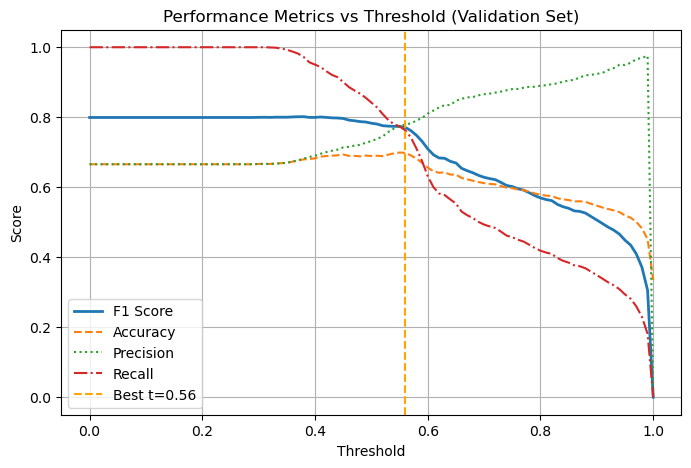

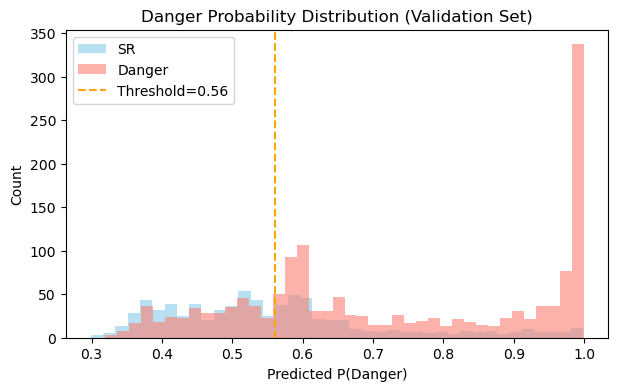

In [30]:

plt.figure(figsize=(8,5))
plt.plot(candidates, f1s, label="F1 Score", linewidth=2)
plt.plot(candidates, accs, label="Accuracy", linestyle="--")
plt.plot(candidates, precs, label="Precision", linestyle=":")
plt.plot(candidates, recs, label="Recall", linestyle="-.")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Best t={best_t:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Performance Metrics vs Threshold (Validation Set)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.hist(prob_danger_val[true_danger_val==0], bins=40, alpha=0.6, label="SR", color="skyblue")
plt.hist(prob_danger_val[true_danger_val==1], bins=40, alpha=0.6, label="Danger", color="salmon")
plt.axvline(best_t, color="orange", linestyle="--", label=f"Threshold={best_t:.2f}")
plt.xlabel("Predicted P(Danger)")
plt.ylabel("Count")
plt.title("Danger Probability Distribution (Validation Set)")
plt.legend()
plt.show()

### Find Mean Predicted Time Horizon

In [ ]:
print("\n================ TIME HORIZON (TEST SET) ================")
print("Using threshold:", window_threshold)

# --- Reload dataset ---
DATA_PATH = os.path.join("..", "Dataset", "raw_RRI_segments.csv")
window_duration_sec = 30

df = pd.read_csv(DATA_PATH)
feature_cols = [c for c in df.columns if c.startswith("r_")]

# Clean dataset like before
X = df[feature_cols].values.astype(np.float32)
y_raw = df["label"].values
mask_good = np.isfinite(X).all(axis=1)
mask_good &= np.isfinite(y_raw) & (y_raw >= 0)
df_clean = df.loc[mask_good].reset_index(drop=True)

aligned_record_ids = df_clean["record_id"].values
y_all = df_clean["label"].values.astype(int)

print("Cleaned dataset:", df_clean.shape)

# --- Compute danger for TEST SET windows ---
prob_danger_test = []

test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test.astype(np.float32)),
                  torch.from_numpy(y_test.astype(np.int64))),
    batch_size=32, shuffle=False
)

model.eval()
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1)
        prob_danger_test.extend((1 - probs[:, 0]).cpu().numpy())

prob_danger_test = np.array(prob_danger_test)

# --- Align lengths (if mismatch) ---
min_len = min(len(prob_danger_test), len(aligned_record_ids))
prob_danger_test = prob_danger_test[:min_len]
aligned_record_ids = aligned_record_ids[:min_len]
y_all = y_all[:min_len]

# --- Find AF onset per record ---
record_af_onset_indices = {}
unique_records = np.unique(aligned_record_ids)

for rid in unique_records:
    idxs = np.where(aligned_record_ids == rid)[0]
    labels = y_all[idxs]
    af_idx = np.where(labels == 2)[0]
    if len(af_idx) > 0:
        record_af_onset_indices[rid] = af_idx[0]

print("Found AF onset in", len(record_af_onset_indices), "records")

# --- Compute time horizon ---
time_horizons = []

for rid, onset_idx in record_af_onset_indices.items():
    idxs = np.where(aligned_record_ids == rid)[0]
    probs = prob_danger_test[idxs]

    first_alert = np.where(probs >= window_threshold)[0]

    if len(first_alert) > 0 and first_alert[0] < onset_idx:
        delta = onset_idx - first_alert[0]
        time_horizons.append(delta * window_duration_sec)

if time_horizons:
    print(f"\nMean predicted time horizon: {np.mean(time_horizons):.2f} s")
    print(f"Median predicted time horizon: {np.median(time_horizons):.2f} s")
    print(f"Detected {len(time_horizons)} AF records early.")
else:
    print("\n⚠️ No early detections found.")


================ TIME HORIZON (TEST SET) ================
Using threshold: 0.56
Cleaned dataset: (14357, 55)
Found AF onset in 19 records

Mean predicted time horizon: 2973.16 s
Median predicted time horizon: 3000.00 s
Detected 19 AF records early.
